<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Cat-boost" data-toc-modified-id="Cat-boost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Cat boost</a></span></li><li><span><a href="#Light-GBM" data-toc-modified-id="Light-GBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Light GBM</a></span></li><li><span><a href="#Выводы-после-обучения:" data-toc-modified-id="Выводы-после-обучения:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выводы после обучения:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#*-В-изначальном-датафрейме-у-нас-был-временной-ряд-с-количеством-заказов-с-интервалов-в-30-минут." data-toc-modified-id="*-В-изначальном-датафрейме-у-нас-был-временной-ряд-с-количеством-заказов-с-интервалов-в-30-минут.-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>* В изначальном датафрейме у нас был временной ряд с количеством заказов с интервалов в 30 минут.</a></span></li></ul></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                    cross_val_score,
                                    TimeSeriesSplit)

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [2]:
try:
    df = pd.read_csv('./datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=True, index_col=[0])

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


* Мы сразу привели дату и время в формат Datetime с помощью параметра parse_dates
* Сделали индексом столбец с датой

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


* Все в порядке, оставшийся формат данных - int  
Проверим, отсортирован ли индекс:

In [4]:
df.index.is_monotonic_increasing

True

* Отлично, индексы отсортированы корректно

## Анализ

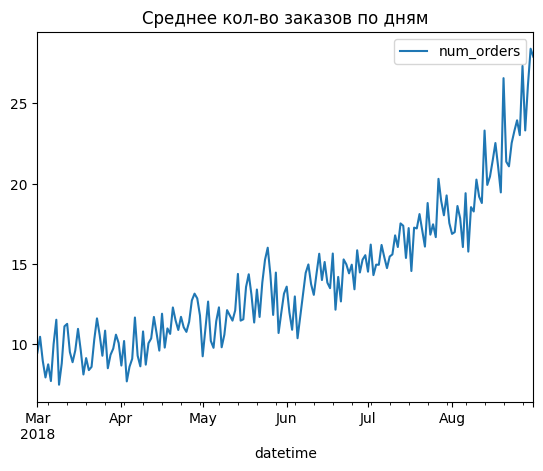

In [5]:
df.resample('1D').mean().plot()
plt.title('Среднее кол-во заказов по дням')
plt.show()

* В целом, мы видим растущий тренд.
* После ресампла до дня явных выпадов нет, нас это устраивает

In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Смущает, что есть интервалы в пол-часа, когда кол-во заказов доходит до 119, стоит посмотреть гистограмму

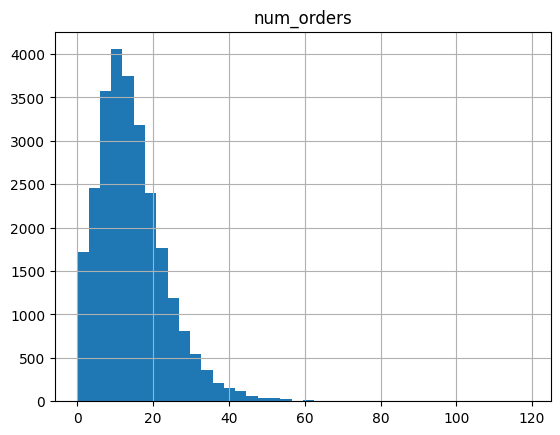

In [7]:
df.hist(bins = 40)
plt.show()

* Значения больше 60 можно откинуть

Доля отброшенных значений не велика, нас это устраивает

In [8]:
#Т.к в задании нас просят предсказать кол-во заказов на час - сделаем ресеплинг
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


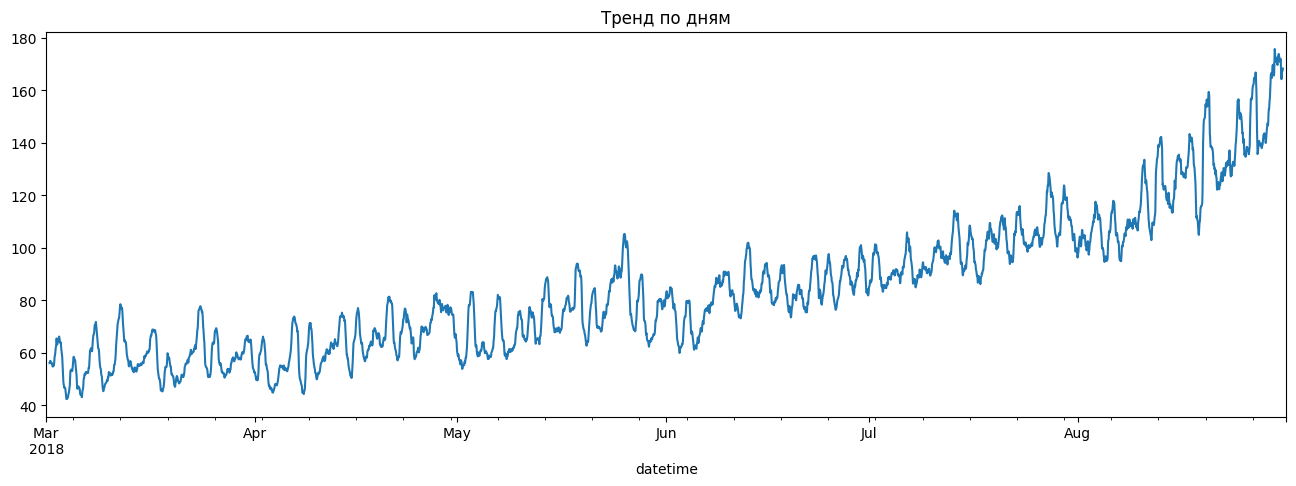

In [9]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot(ax=plt.gca(), figsize = (16,5))
plt.title('Тренд по дням')
plt.show()

* Мы видим явно растущий тренд. С каждым днем заказов становится все больше и в последние дни количество заказов стало больше 3500

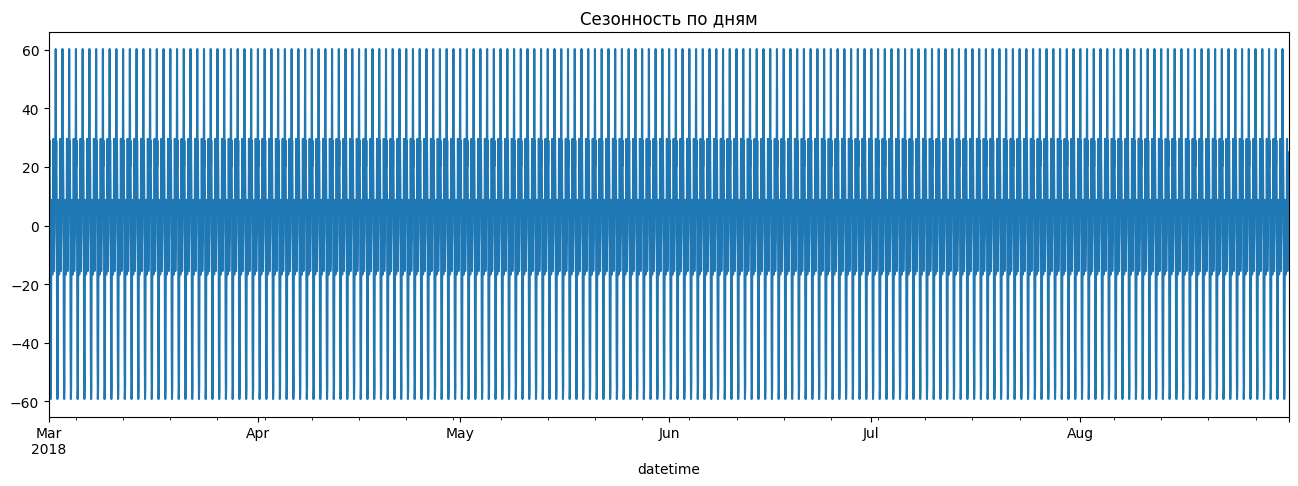

In [10]:
decomposed = seasonal_decompose(df)
decomposed.seasonal.plot(ax=plt.gca(), figsize = (16,5))
plt.title('Сезонность по дням')
plt.show()

* Ничего не понятно, стоит взять меньший период

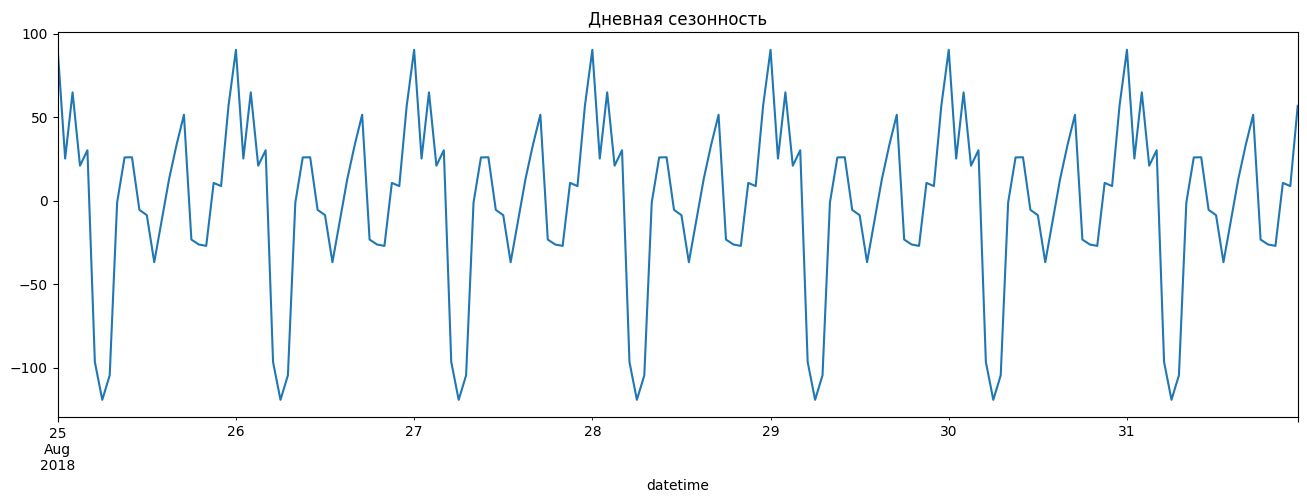

In [11]:
decomposed = seasonal_decompose(df.tail(24*7))
decomposed.seasonal.plot(ax=plt.gca(), figsize = (16,5))
plt.title('Дневная сезонность')
plt.show()

* Видно, что имеется дневная сезонность. Посмотрим еще ближе

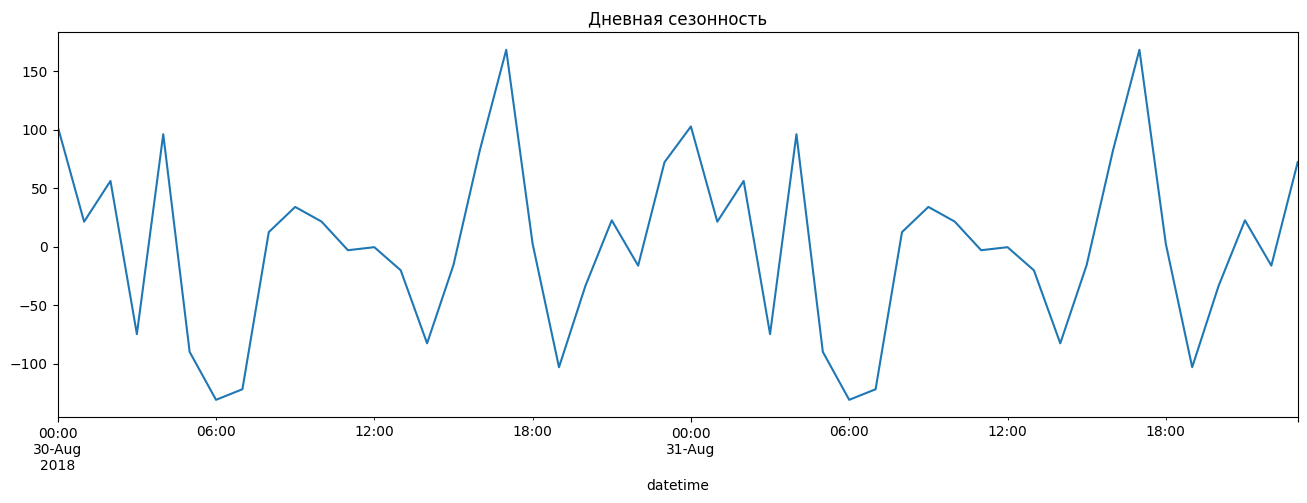

In [12]:
decomposed = seasonal_decompose(df.tail(24*2))
decomposed.seasonal.plot(ax=plt.gca(), figsize = (16,5))
plt.title('Дневная сезонность')
plt.show()

* Спад происходит в 6 утра, а ближе к 18 идет сильный скачок вверх

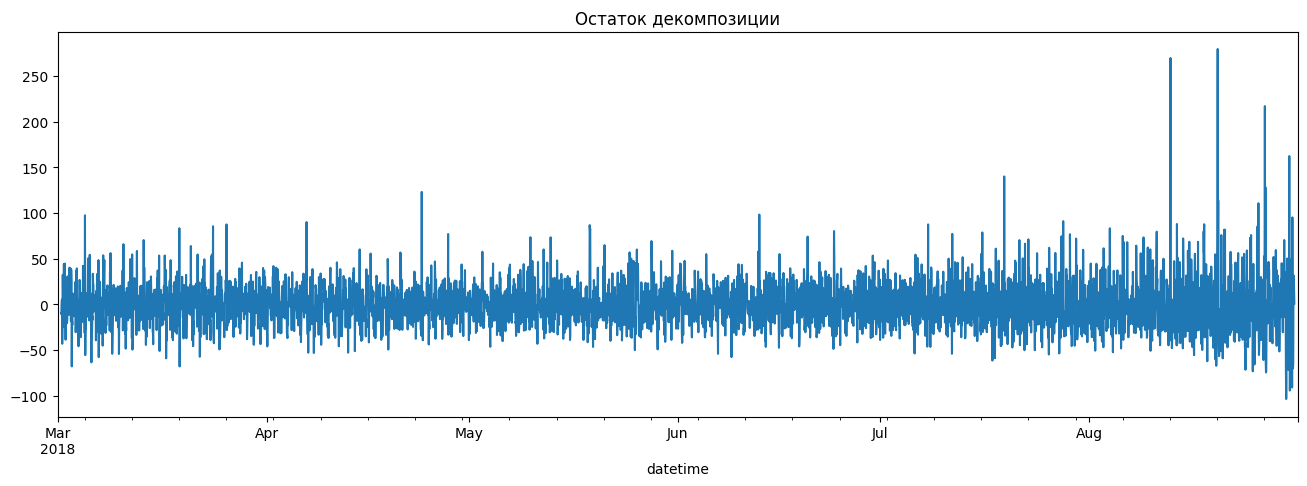

In [13]:
decomposed = seasonal_decompose(df)
decomposed.resid.plot(ax=plt.gca(), figsize = (16,5))
plt.title('Остаток декомпозиции')
plt.show()

* Мы видим, что остаток от декомпозиции находится примерно на одном уровне и в целом нам удалось разложить динамику показателя на сезонную и трендовую составляющие.

In [14]:
df.isna().sum()

num_orders    0
dtype: int64

In [15]:
# Создадим функцию для дополнительных полей
def add_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

add_features(df,2,24)

df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN


## Обучение

In [16]:
train,test = train_test_split(df,shuffle=False,test_size=0.2)

for df in (train,test):
    print(df.shape)


(3532, 6)
(884, 6)


In [17]:
# Из тренировочной выборки отбросим NA
train = train.dropna()
train.shape

(3508, 6)

* Размеры выборок устраивают

In [18]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

### Линейная регрессия

In [19]:
model_lr = LinearRegression()

res_lr = -cross_val_score(model_lr,X_train, y_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()

print ('Среднее количество заказов = {}'.format(y_train.mean()))
print ('RMSE Линейной регрессии на тренировочной выборке = {:,.2f}'.format(res_lr))

Среднее количество заказов = 74.42702394526796
RMSE Линейной регрессии на тренировочной выборке = 29.87


### Дерево решений

In [20]:
model_dr = DecisionTreeRegressor()
param_grid_dr = {
    'max_depth': [3,9,10]
}

gsearch_dr = GridSearchCV(model_dr,
                          param_grid=param_grid_dr,
                          cv = TimeSeriesSplit(n_splits=5),
                          n_jobs = -1,
                          scoring = 'neg_root_mean_squared_error')

gsearch_dr.fit(X_train,y_train)
res_dr = -gsearch_dr.best_score_
#res_dr = -cross_val_score(model_dr,X_train, y_train, 
#                         cv = TimeSeriesSplit(n_splits=24), 
#                         n_jobs = -1, 
#                         scoring = 'neg_root_mean_squared_error').mean()
#
print ('RMSE Дерева решений на тренировочной выборке = {:,.2f}'.format(res_dr))

RMSE Дерева решений на тренировочной выборке = 28.95


### Cat boost

In [21]:
catboost = CatBoostRegressor(logging_level = 'Silent', iterations = 100) #Тут пробовал и 1000, но все равно результат ниже, чем у LR
cb_grid = {'learning_rate': [0.1],
       'depth': [6],
       'l2_leaf_reg': [3, 5]}
grid_cat  = GridSearchCV(estimator=catboost, 
                     param_grid = cb_grid, 
                     cv = TimeSeriesSplit(n_splits=3), 
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error')

grid_cat.fit(X_train, y_train)

res_cat = -grid_cat.best_score_

print ('RMSE CAT Boost на тренировочной выборке = {:,.2f}'.format(res_cat))

RMSE CAT Boost на тренировочной выборке = 25.34


### Light GBM

In [22]:
model_lgbm = LGBMRegressor(random_state=12345) 
# Сократил количество параметров, яндекс долго висел и с 3 параметрами дал результат 25.42, оставил те, которые выбрал
lgbm_grid = {'learning_rate': [0.1],
             'max_depth': [5],
             'num_leaves': [100]}

grid_lgbm = GridSearchCV(estimator=model_lgbm, 
                     param_grid = lgbm_grid, 
                     cv = TimeSeriesSplit(n_splits=3), 
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error')


grid_lgbm.fit(X_train, y_train)

res_lgbm = -grid_lgbm.best_score_

print ('MAE LGBM на тренировочной выборке = {:,.2f}'.format(res_lgbm))

MAE LGBM на тренировочной выборке = 25.42


### Выводы после обучения:
* Все модели отработали примерно одинаково с довольно высокой средней ошибкой.
* Наша модель может ошибиться на 23 заказа в час. При среднем 74 доля достаточно высока

In [23]:
print ('Результаты моделей:')
pd.DataFrame(data = [res_lr, 
                     res_dr, 
                     res_cat, 
                     res_lgbm], 
                    index = ['Линейная регрессия',
                              'Дерево решений',
                              'CAT',
                              'LGBM'],
                    columns = ['MAE']).style.format('{:.2f}')

Результаты моделей:


,MAE
Линейная регрессия,29.87
Дерево решений,28.95
CAT,25.34
LGBM,25.42


## Тестирование

In [24]:
pred_test = grid_lgbm.predict(X_test)
res_test = mean_squared_error(pred_test, y_test)**0.5
print ('RMSE Lшпре GBM на тестовой выборке = {:,.2f}'.format(res_test))

RMSE Lшпре GBM на тестовой выборке = 44.27


## Итоговые выводы

#### * В изначальном датафрейме у нас был временной ряд с количеством заказов с интервалов в 30 минут.
* Мы провели небольшую предобработку данных.
* После исключения аномалий мы разделили выборку на тестовую и тренировучную.
* На тренировочной выборке мы протестировали 4 модели и остановились на Линейной регрессии
* Итоговый RMSE на тестовой выборке получился 44.27 на тестовой выборке, что удовлетворяет требованиям ТЗ.

In [25]:
preds = grid_lgbm.predict(X_test['27-08-2018':])
pred_df = pd.Series(index = X_test['27-08-2018':].index, data = preds)

C:\Users\atropinskiy\AppData\Local\Temp\ipykernel_29332\898546805.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  preds = grid_lgbm.predict(X_test['27-08-2018':])
C:\Users\atropinskiy\AppData\Local\Temp\ipykernel_29332\898546805.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pred_df = pd.Series(index = X_test['27-08-2018':].index, data = preds)


C:\Users\atropinskiy\AppData\Local\Temp\ipykernel_29332\3452276157.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  ax2 = y_test['27-08-2018':].plot(x=plt.gca(), figsize = (16,5), label = 'Real')


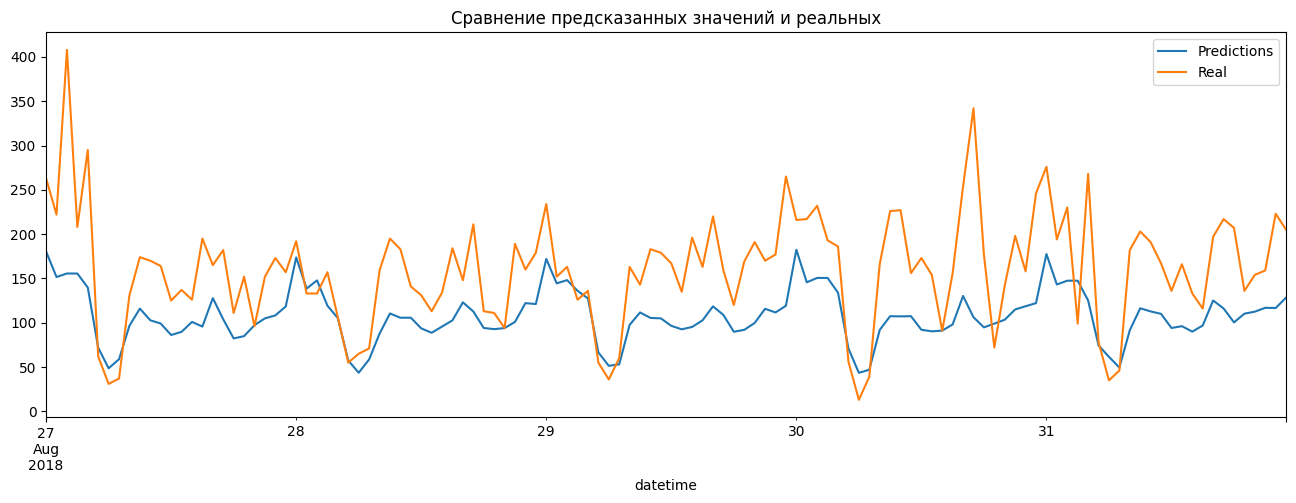

In [26]:
ax1 = pred_df.plot(x=plt.gca(), figsize = (16,5), label = 'Predictions')
ax2 = y_test['27-08-2018':].plot(x=plt.gca(), figsize = (16,5), label = 'Real')
plt.title ('Сравнение предсказанных значений и реальных')
plt.legend()
plt.show()

* Мы видим, что модель дает более пессимистичные прогнозы, но форму и сезонные компоненты она учитывает.
* Как вариант можно обучить модель на более актуальном периоде, либо использовать модели, где можно усилить вес последних данных.
* Тем не менее RMSE соответствует ТЗ, чего от нас и требовалось.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Данные загружены и подготовлены
- [X]  Данные проанализированы
- [X]  Модель обучена, гиперпараметры подобраны
- [X]  Качество моделей проверено, выводы сделаны
- [X]  Значение *RMSE* на тестовой выборке не больше 48